#  Mathematics of Reinforcement Learning: Homework Sheet 7

In this exercise class we compare different ways of estimating the value function $V^\pi$ when the transition probabilities $p$ are not known.

Make sure you have all the necessary packages (numpy, gymnasium and matplotlib) installed. You can use `conda install <package>` or `pip install <package>`.

In [1]:
#It may be possible to run the following line of code to install packages:
#!pip install gymnasium[toy-text]

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

### Frozen Lake Example

In this homework sheet we use the environment Frozen Lake by Gymnasium (see https://gymnasium.farama.org/environments/toy_text/frozen_lake/). 

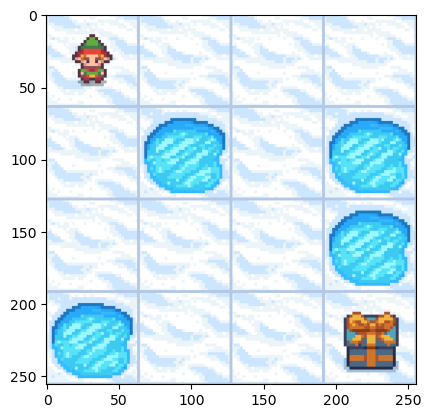

In [2]:
#In the following way an environment env is created:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

#Visualisation:
env.reset()
plt.imshow(env.render())

#### Short repetition:
The following action and observation spaces are used

| Action space | Observation space |
| --- | --- |
|  `Discrete(4)`| `Discrete(16)`| 

`Discrete(n)` denotes the integers $0,...,n-1$. 

### Action space
The action indicates the direction in which the player is moved. The following encoding is used
* 0: Move left
* 1: Move down
* 2: Move right
* 3: Move up

### Observation space
The observation value represents the players current position on the board.

# Important changes
The following changes were discussed in Homework sheet 5.

We define the following "Twin" Markov Decision Model, which is slightly modified from the Frozen Lake Example. \
Let 
 - $S=\{0,1,\dots, 16\}$, where a new state 16 is added. Assume there is a labelling function $m\colon S \to \{$'S','F', 'H', 'G', 'E'$\}$ which labels each state as start state 'S', frozen state 'F', hole state 'H', goal state 'G' or end state 'E'. We assume that only for the newly added state 16 does $m(16)=$'E' hold.  
 - $A=\{0,1,2,3\}$, same action space as in the Frozen Lake example.
 - $D= S\times A$
 - The transition probability function $p$ is defined as follows:
   * For all states $s\in S$ with $m(s) =$'S' or $m(s)=$'F', use the same transition probability function as in the Frozen Lake example
   * For all states $s\in S$ with $m(s) =$'H' or $m(s) =$'G' set $p(16\mid s,a) = 1$ for all actions $a\in A$
   * For the state $s\in S$ with $m(s) =$'E' set $p(16\mid s,a) = 1$ for all actions $a\in A$
 - For all $a\in A$ the reward function for the state $s\in S$ with $m(s)=$'G' is defined as $r(s,a)= 1$, for all other state-action combinations the reward function is set to 0.
 - We add a discounting factor $\gamma = 0.95$.

# New changes
We apply a new change. The change concerns the definition of the transition probability function $p$. 
* For all states $s\in S$ with $m(s) =$'S' or $m(s)=$'F', the player moves in the intended direction with probability 1/3, otherwise moves in either perpendicular direction with equal probability of 1/3 in both directions.

For example, if the action is left, then:

* P(move left)=1/3
* P(move up)=1/3
* P(move down)=1/3

In [3]:
gamma = .95 # given by the Markov Decision Model

In [4]:
original_map = ["SFFF", "FHFH", "FFFH", "HFFG"]   #"S" means start, "F" frozen, "H" hole and "G" goal 

# function zips together all rows of the lake into a sixteen character string
def label(s, layout):
    #function that maps an input state s to the corresponding label in the map layout 
    map_combined = "".join(layout)
    if s == len(map_combined):
        return "E"
    return map_combined[s]

In [5]:
assert label(0, original_map) == "S"

**Task 1:** Adapt the function `step(state, a, map = original_map)` which takes as input an observation `state`, an action `a` and a map `layout` and returns the next observation and a reward according to the 'Twin' Markov Decision Model with the new random transition probabilities.

In [6]:
# Help function for step() that returns next_state, based on (state, action) pair for state "S", "F"
def deterministic_step(state, a, layout = original_map):
    next_state = state
    if a == 0: #move left
        if state%4 != 0:
            next_state = state - 1
    elif a == 1:  #move down
        if state//4 != 3:
            next_state = state + 4
    elif a == 2: #move right
        if state%4 != 3:
            next_state = state + 1
    elif a == 3: #move up:
        if state//4 != 0:
            next_state = state - 4
    else:
        raise Exception("Something wrong")
    return next_state

In [7]:
def step(state, a, layout = original_map):
    """
    This function computes the next state and reward given current state s and chosen action a in 
    the "Twin" Markov Decision Model.  

    Task: Rewrite this function to incorporate the new changes.
    """
    
    if state == 16 or label(state, layout) == "H":   # check if end state or hole state
        return 16, 0 
    if label(state, layout) == "G":  #check if goal state
        return 16, 1
    
    
    #the only remaining cases are that the label of the state is either "F" or "S"
    # ---- TODO ---- 
    
    # construct something that returns next state (randomness) and corresponding reward
    # Only "F" or "S" to consider
    
    # for every state, action pair need 3 eligble new states that remain in the state space
    # every action has its own 3 components
    action_space_mod = {0: [0,1,3], 1: [1,0,2], 2: [2,1,3], 3:[3,1,2]}
    
    # check new state under every action
    actions_a = action_space_mod[a]
    possible_states = [deterministic_step(state, action, layout = original_map) for action in actions_a]
    
    # choose with randomness which new state is obtained
    next_state = np.random.choice(possible_states, p=[1/3, 1/3, 1/3])
    
    # also possible to make RANDOM CHOICE on ACTION
    
    # ---- TODO ---- 

    return next_state, 0

In [8]:
def previous_optimal_policy(state):
    # this policy was calculated to be optimal in homework sheet 5 (without the random actions) 
    optimal_policy_list = [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0, 0]
    
    return optimal_policy_list[state]


**Task 2:** Implement a function `sample_path(start_state, policy, layout = original_map, max_rollouts = 50)` that simulates a Markov Decision Process in the "Twin" Markov Decision Model following a given policy `policy`. The function should return the following list: 
$$[(s_0,r_0),(s_1,r_1),\dots, (s_m,r_m)],$$
with $s_0 = $ `start_state` and where we denote with $s_i$ the visited states and with $r_i$ the obtained rewards given ($s_i$, `policy`($s_i$)). Stop the simulation at timepoint $m$, if $s_m = 16$ or at the latest if  $m \geq $ `max_rollouts`.

In [131]:
def sample_path(start_state, policy, layout = original_map, max_rollouts = 50):
    # ---- TODO ---- 
    # SOLUTION
    
    visited_state_reward_pairs = []
    state = start_state
    
    for _ in range(max_rollouts):
        
        action = policy(state)
        new_state, reward = step(state, action, layout)
        visited_state_reward_pairs.append((state, reward))
        
        if state == 16:
            break

        state = new_state
        
    return visited_state_reward_pairs

## First Visit Monte Carlo Estimation

**Task 3:** Implement a function `MC_update(state, V, learning_rate, acc_reward)` that updates the value function `V` using the standard Monte Carlo update rule:
$$ \hat{V}_{m+1}(s) = \hat{V}_{m}(s)+\alpha_{m+1}(s)\big[\sum_{n=0}^N\gamma^n\cdot R_n^{m+1}-\hat{V}_m(s)\big],$$
where the input `state` is $s$, `learning_rate` is $\alpha_{m+1}(s)$ and `acc_reward` is $\sum_{n=0}^N\gamma^n\cdot R_n^{m+1}$. Return as a list $\hat{V}_{m+1}$.

In [134]:
def MC_update(state, V, learning_rate, acc_reward):
    # ---- TODO ---- 
    # SOLUTION
    
    V[state] = V[state] + learning_rate * (acc_reward - V[state])
    return V

**Task 4:** Implement a function `first_visit_MC(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = [])` that approximates the state-value function using the "first visit Monte Carlo estimation". The total number of rollouts of the Markov Decision Process following the policy `policy` should be equal to `iterations`. 

Start with a random initialisation of the value function (each entry should be uniformly distributed in [0, 1]).

Regarding the optional input `iterations_to_save`:
 * if `iterations_to_save=[]`: return $\hat{V}_m$, where $m=$ `iterations`
 * otherwise: return the list $[\hat{V}_n$ for $n$ in iterations_to_save $]$

In [13]:
def first_visit_MC(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = []):
    # ---- TODO ---- 
    # !!!! WRONG
    
    # !!! Assumes iterations_to_save
    
    # initialize state_space and discount_factor depending on max_rollouts
    state_space = list(range(17))
    discount_factor = gamma**np.arange(max_rollouts+1)
    
    # value function for every state basically
        
    # Initialize V_0 since LLN V_0 not too important
    value_function = np.random.binomial(1, 0.5, len(state_space))
    
    # define value function to return
    if iterations_to_save == []:
        iterations_to_save = [iterations-1]
    
    # value function on every state is improved by the amount of itereations
    for i in range(iterations):

        # acc_reward, requires sample path and its weighted sum
        acc_reward = np.zeros(len(state_space))
        for state in state_space:
            sample = sample_path(state, policy, layout = original_map, max_rollouts = max_rollouts)
            sample = np.array(sample)
            
            acc_reward[state] = np.sum(sample[:,1]*discount_factor)
    
        value_function = MC_update(0, value_function, 1/(i+1), acc_reward) # state doesn't matter
        
        if i in iterations_to_save:
            return value_function

In [149]:
def first_visit_MC(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = []):
    # ---- TODO ---- 
    # SOLUTION
    
    V = np.random.random((17,))   #random Value initialization
    if iterations_to_save == []:
        iterations_to_save = [iterations-1]
    
    output = []
    for iteration in range(iterations):
        #do a rollout and save the state reward pairs
        start_state = 0
        visited_state_reward_pairs = sample_path(start_state, policy)
        visited_state_reward_pairs = np.array(visited_state_reward_pairs)

        visited_states = []
        #go through the visited state reward pairs 
        for i in range(len(visited_state_reward_pairs)):
            state, reward = visited_state_reward_pairs[i]

            #update the value function at the first visit
            if state not in visited_states:
                visited_states.append(state)
                accumulated_reward = np.sum(gamma**np.arange(len(visited_state_reward_pairs)-i) * \
                                                             visited_state_reward_pairs[i:,1])
                V = MC_update(state, V, 1/(iteration + 1), accumulated_reward)
        
        if iteration in iterations_to_save:
            output.append(list(V))

    return output

#test section: 
test_V = first_visit_MC(10000, previous_optimal_policy, iterations_to_save = [])
print(test_V)
assert np.isclose(test_V[0][-1],0.0)
assert test_V[0][0] > 0.015 
assert test_V[0][0] < 0.035

[[0.02336409644072613, 0.016852976116381646, 0.04020501627221459, 0.15837649757500166, 0.03564571362698722, 0.0, 0.16357761351924385, 0.21284896067065356, 0.07249429604640892, 0.2096257831063591, 0.5675349100915359, 0.6312850677838443, 0.030776401212222197, 0.1404692279448922, 0.6079674731747067, 0.9360052843893027, 0.0]]


In [165]:
#test section: 
test_V = first_visit_MC(1000, previous_optimal_policy, iterations_to_save = [999])
assert np.isclose(test_V[-1],0.0)
assert test_V[0] > 0.015 
assert test_V[0] < 0.035

**Task 5:** Plot the evolution of $\hat{V}_m(0)$, for the given iterations in `iterations_to_save`. Plot 10 independent runs of the function `first_visit_MC`. Use the policy `previous_optimal_policy`.

In [14]:
iterations_to_save = [10 * i for i in range(101)]
# ---- TODO ---- 



## Temporal Difference Estimation

**Task 6:** Implement a function `TD0_update(current_state, reward, next_state, V, learning_rate)` that updates the value function `V` according to the TD(0) update rule.

In [11]:
def TD0_update(current_state, reward, next_state, V, learning_rate):
    # ---- TODO ---- 
    V[current_state] = V[current_state] + learning_rate * (reward + gamma * V[next_state] - V[current_state])
    return V

**Task 7:** Implement a function `TD0(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = [])` that approximates the state-value function using the "TD(0) estimation". The total number of rollouts of the Markov Decision Process following the policy `policy` should be equal to `iterations`. 

Start with a random initialisation of the value function (each entry should be uniformly distributed in [0, 1]).

For the optional input `iterations_to_save`, see Task 4.

Unlike in task 4, update the value function not only on the first visits, but on all visits.

*Tip:* Try different learning rates.

In [93]:
def TD0(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = []):
    # ---- TODO ---- 

    V = np.random.random((17,))   #random Value initialization
    if iterations_to_save == []:
        iterations_to_save = [iterations-1]
    
    output = []
    
    for iteration in range(iterations):
        #do a rollout and save the state reward pairs
        start_state = np.random.choice(17)
        visited_state_reward_pairs = sample_path(start_state, policy)
        visited_state_reward_pairs = np.array(visited_state_reward_pairs)
        #go through the visited state reward pairs 
        for i in range(len(visited_state_reward_pairs)):
            state, reward = visited_state_reward_pairs[i]
            
            # need condition on last state to not swallow information WRONG, only 16 is considered as it would've aborted
            # earlier otherwise anyway true, but only to give an exisiting state as otherwise out of index
            if i == len(visited_state_reward_pairs)-1:
                next_state = 16
            else:
                next_state, next_reward = visited_state_reward_pairs[i+1]
            
            #update the value function at the first visit
            V = TD0_update(state, reward, next_state, V, 0.01)
                    
        if iteration in iterations_to_save:
            output.append(list(V))

    return output


In [94]:
#test section: 
test_V = TD0(10000, previous_optimal_policy, iterations_to_save = [9999])
print(test_V)
#assert np.isclose(test_V[0][-1],0.0)
assert test_V[0][0] > 0.015 
#assert test_V[0][0] < 0.035 # DOESNT WORK IN SOLUTION NEITHER

[[0.04704658268407341, 0.028446855884265522, 0.05227865748254227, 0.029459495437823325, 0.03868321575425418, 0.0026056538184183954, 0.10407853067611876, 0.0030396249792196853, 0.09588368665824128, 0.24866624295426615, 0.2818060599199566, 0.00302800928798758, 0.003391273021289938, 0.4048521984228992, 0.6110067472413117, 1.0028455840416455, 0.0022433978534198385]]


**Task 8:** Visualise the convergence as in task 5.

In [84]:
def sample_path(start_state, policy, layout = original_map, max_rollouts = 50):
    # ---- TODO ---- 
    
    visited_state_reward_pairs = []
    state = start_state
    
    for _ in range(max_rollouts):
        
        action = policy(state)
        new_state, reward = step(state, action, layout)
        visited_state_reward_pairs.append((state, reward))
        
        if state == 16:
            break

        state = new_state
        
    return visited_state_reward_pairs

In [72]:
def TD0(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = []):
    # ---- TODO ---- 
    
    V = np.random.random((17,))   #random Value initialization
    if iterations_to_save == []:
        iterations_to_save = [iterations-1]
        
    output = []
    #state_visits = np.zeros((17,))
    for iteration in range(iterations):
        #do a rollout and save the state reward pairs
        start_state = np.random.choice(17)
        visited_state_reward_pairs = sample_path(start_state, policy)
        visited_state_reward_pairs = np.array(visited_state_reward_pairs)
        #go through the visited state reward pairs 
        for i in range(len(visited_state_reward_pairs)):
            state, reward = visited_state_reward_pairs[i]

            #update the value function at every visit

            #compute the next state
            if i == len(visited_state_reward_pairs)-1:
                #for rare cases the next state doesn't have to be the terminal state 16 
                next_state = 16
            else:
                next_state = visited_state_reward_pairs[i+1][0]
            #state_visits[state] += 1
            V = TD0_update(state, reward, next_state, V, .01)#1/(state_visits[state]))
        
        if iteration in iterations_to_save:
            output.append(list(V))
    return output

#test section: 
test_V = TD0(10000, previous_optimal_policy, iterations_to_save = [9999])
print(test_V)
# assert np.isclose(test_V[0][-1],0.0)
assert test_V[0][0] > 0.015 
assert test_V[0][0] < 0.035

[[0.05491516992010897, 0.025003639362739444, 0.04764481779463096, 0.03039709033567887, 0.04757294006756572, 0.004154785131100509, 0.08149569189767619, 0.004878935035780212, 0.08674630074919866, 0.2285190141960037, 0.2525606830078735, 0.004572045336583721, 0.005154539304172605, 0.3886309417319315, 0.5617595885285906, 1.0044933593095136, 0.003519268577034523]]


AssertionError: 

In [ ]:
#test section: 
test_V = TD0(10000, previous_optimal_policy, iterations_to_save = [9999])
print(test_V)
#assert np.isclose(test_V[0][-1],0.0)
assert test_V[0][0] > 0.015 
#assert test_V[0][0] < 0.035 # DOESNT WORK IN SOLUTION NEITHER

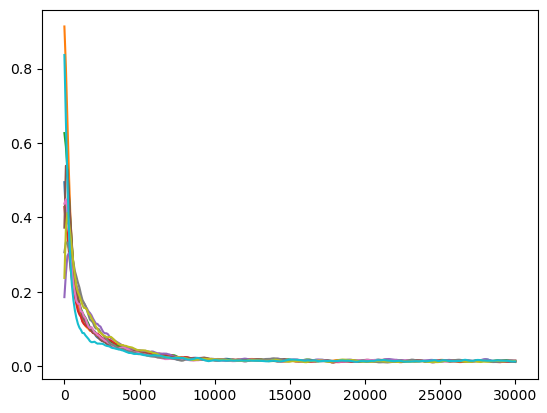

In [43]:
iterations_to_save = [100 * i for i in range(301)]
# ---- TODO ---- 

for _ in range(10):
    V = TD0(30001, previous_optimal_policy, iterations_to_save = iterations_to_save)
    plt.plot(iterations_to_save, [v[0] for v in V])
plt.show()


**Task 9:** Implement a function `TD2_update(current_state, acc_reward, third_next_state, V, learning_rate)` that updates the value function `V` according to the TD(2) update rule.

In [122]:
def TD2_update(current_state, acc_reward, third_next_state, V, learning_rate):
    # ---- TODO ---- 
    V[current_state] = V[current_state] + learning_rate * (acc_reward + gamma**3 * V[third_next_state] - V[current_state])
    return V

**Task 10:** Implement a function `TD2(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = [])` that approximates the state-value function using the "TD(2) estimation". The total number of rollouts of the Markov Decision Process following the policy `policy` should be equal to `iterations`. 

Start with a random initialisation of the value function (each entry should be uniformly distributed in [0, 1]).

For the optional input `iterations_to_save`, see Task 4.

In [143]:
def TD2(iterations, policy, layout = original_map, max_rollouts = 50, iterations_to_save = []):
    # ---- TODO ---- 

    V = np.random.random((17,))   #random Value initialization
    if iterations_to_save == []:
        iterations_to_save = [iterations-1]
    
    output = []
    
    for iteration in range(iterations):
        #do a rollout and save the state reward pairs
        start_state = np.random.choice(17)
        visited_state_reward_pairs = sample_path(start_state, policy)
        visited_state_reward_pairs = np.array(visited_state_reward_pairs)
        
        # to cope with end of rollout and possibility to consider last actual state of the rollout
        vector_extension = np.zeros((3,2),dtype=int) # to cope with end of rollout
        vector_extension[:,0] = 16 # set end of rollout to terminal state 16
        visited_state_reward_pairs  = np.vstack([visited_state_reward_pairs,vector_extension])
        
        #go through the visited state reward pairs 
        for i in range(len(visited_state_reward_pairs)-3): # DOESNT CONSIDER ROLLOUTS W/ LENGTH 1, NO NEED ACTUALLY
            state, reward = visited_state_reward_pairs[i]
            
            #update the value function at every visit
            third_next_state = visited_state_reward_pairs[i+3][0]
            acc_reward = np.sum(gamma**np.arange(3) * visited_state_reward_pairs[i:i+3,1])

            #update the value function at the first visit
            V = TD2_update(state, acc_reward, third_next_state, V, 0.01)
                    
        if iteration in iterations_to_save:
            output.append(list(V))

    return output

    
#test section: 
test_V = TD2(10000, previous_optimal_policy, iterations_to_save = [9999])
print(test_V)
assert np.isclose(test_V[0][-1],0.0)
assert test_V[0][0] > 0.015 
assert test_V[0][0] < 0.035

[[0.02859506515842713, 0.01613136775170269, 0.03364483843795753, 0.01621830054167343, 0.029715974896440144, 1.1944023524599256e-06, 0.07616717639087381, 4.11699807587773e-06, 0.05883940457812424, 0.1985190673046784, 0.23518774962128056, 2.474699286363205e-06, 4.6911147610157865e-06, 0.3717658696525177, 0.5609222013631162, 1.0000022651828948, 6.077996980937211e-07]]


AssertionError: 

**Task 11:** Visualise the convergence as in task 5.

In [ ]:
iterations_to_save = [100 * i for i in range(301)]
# ---- TODO ---- 


**Task 12:** Implement a function `visualise_results(method, iterations, number_of_samples)` that, for a given input method `method`, visualises in 2 separate plots for each state the mean value and the method variance of the state value. Run in total `number_of_samples` many runs of the input method with each `iterations` many iterations.

For the state `s=16` you can return this information in a print-statement. For all other states you can use a similar visualisation as shown in the last programming sheet.

In [138]:
def visualise_results(method, iterations, number_of_samples):
    # ---- TODO ----
    
    data = [method(iterations, previous_optimal_policy)[0] for _ in range(number_of_samples)]
    data = np.array(data)

    variances = np.var(data, axis = 0)
    assert len(variances) == 17

    values = np.mean(data, axis = 0)
    assert len(variances) == 17

    terminal_state_variance = variances[-1]
    terminal_state_value = values[-1]

    variances = variances[:-1]
    values = values[:-1]
    variances = variances.reshape((4,4))[::-1]
    values = values.reshape((4,4))[::-1]
    
    #fig, ax = plt.subplots()
    #im = ax.imshow(variances)

    fig, ax = plt.subplots(1,2, figsize = (10, 4))
    c = ax[1].pcolormesh(np.arange(4), np.arange(4), variances)
    ax[1].set_title('Method Variance in each state')
    fig.colorbar(c, ax=ax[1])

    c = ax[0].pcolormesh(np.arange(4), np.arange(4), values)
    ax[0].set_title('Mean Value in each state')
    fig.colorbar(c, ax=ax[0])

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    print(f"The terminal state 16 has mean value {terminal_state_value} with variance {terminal_state_variance}")
    
    plt.show()    


The terminal state 16 has mean value 0.0 with variance 0.0


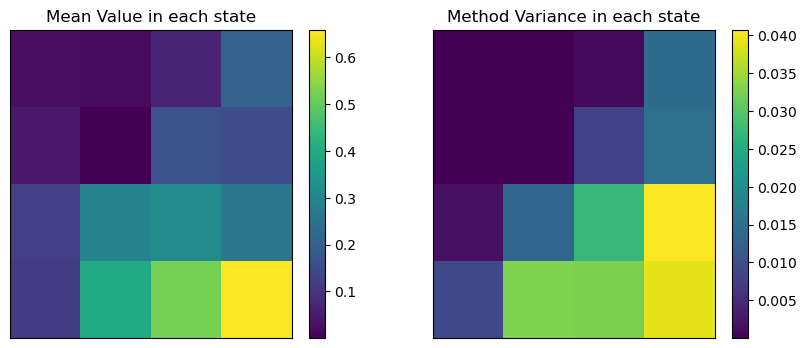

In [151]:
visualise_results(first_visit_MC, 10000, 50)

The terminal state 16 has mean value 0.26497366564583624 with variance 0.0408834003211179


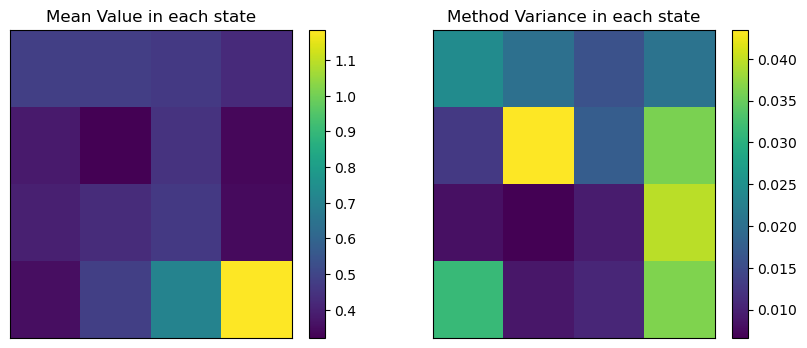

In [140]:
visualise_results(TD0, 1000, 10)

The terminal state 16 has mean value 0.16379582366026196 with variance 0.0013579042901479949


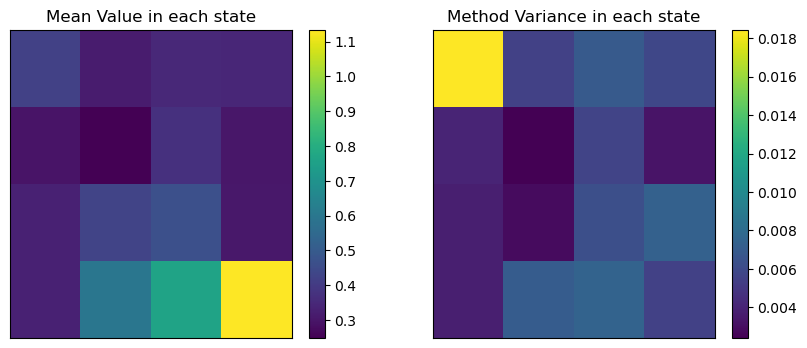

In [144]:
visualise_results(TD2, 1000, 10)

**Task 13:** Implement a function `visualize_convergence(state, iterations, number_of_samples)` that, for a given input state `state`, visualises in a single plot how the 3 different methods behave in approximating $\hat{V}_m($ `state` $)$. Run in total `number_of_samples` many runs of the input method with each `iterations` many iterations.

Visualise the results in a similar way to the first figure at: https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html 

Use 1 standard deviation as the area around the mean method approximation.

In [145]:
def visualize_convergence(state, iterations, number_of_samples):
    assert iterations>=1000 
    iterations_to_save = [iterations//1000 * i for i in range(1001)]
    # ---- TODO ---- 
    
    methods = [first_visit_MC, TD0, TD2]
    method_labels = ["MC", "TD0", "TD2"]
    colors = ["r", "b", "g"]
    for i in range(3):
        method = methods[i]
        data = [method(iterations+1, previous_optimal_policy, iterations_to_save = iterations_to_save) for _ in range(number_of_samples)]
        data = np.array(data)[:,:,state]
    
        std = np.std(data, axis = 0)
        values = np.mean(data, axis = 0)
    
        
        plt.plot(iterations_to_save, values, f"{colors[i]}--", label=method_labels[i])
        plt.fill(np.concatenate([iterations_to_save, iterations_to_save[::-1]]),
                 np.concatenate(([values[j] - 1 * std[j] for j in range(len(values))],
                                 [values[j] + 1 * std[j] for j in range(len(values[::-1])-1,-1,-1)])),
                                  alpha=.2, fc=colors[i], ec="None")
        
    plt.legend()
    plt.title("Convergence visualisation")
    plt.ylabel("Value")
    plt.xlabel("Iteration")
    plt.show()


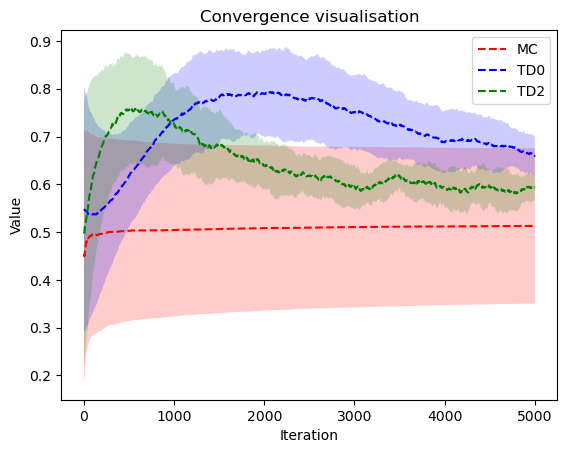

In [148]:
visualize_convergence(14, 5500, 20)

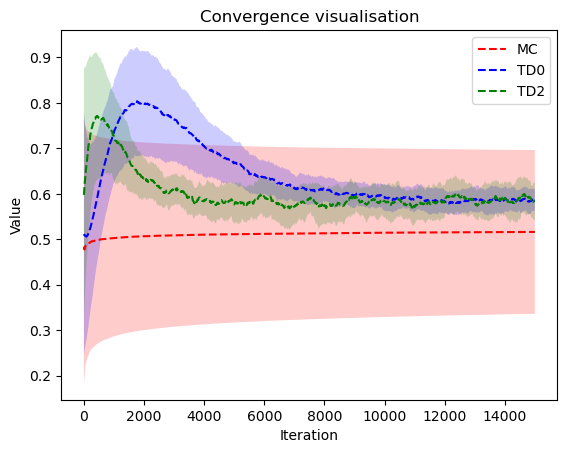

In [16]:
# DO NOT RUN THIS LINE OF CODE.
# your figure should look similar to this